In [1]:
# Importing lIbraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount("/content/drive")
import sys
sys.path.append('/content/drive/My Drive/')
import utils
import plot_utils
import nse_utils




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# File paths
anto_file = ("/content/drive/MyDrive/Datasets/raw/raw/ANTO2_USGS.txt")

anto_file_sim = ("/content/drive/MyDrive/Datasets/raw/raw/ANTO2_sim.txt")


In [3]:
# Read and preprocess the USGS data
df_anto = utils.read_usgs_data(anto_file, header_line=33)


# Read and preprocess simulation data
df_anto_sim = utils.read_simulation_data(anto_file_sim, header_line=6)



In [4]:
# Merge df_anto and df_anto_sim
df_anto_merge = pd.merge(df_anto, df_anto_sim, on='datetime', how='inner')




In [5]:
# Replace "CST" with "UTC" in the 'timezone' column
df_anto_merge['timezone'] = df_anto_merge['timezone'].replace('CST', 'UTC')


# Display the modified DataFrame
print(df_anto_merge.head())


    org  site_num                  datetime timezone  USGS_Discharge quality  \
0  USGS   7336200 2007-01-01 06:00:00+00:00      UTC         13900.0  A:[91]   
1  USGS   7336200 2007-01-01 12:00:00+00:00      UTC         10100.0  A:[91]   
2  USGS   7336200 2007-01-01 18:00:00+00:00      UTC          6870.0  A:[91]   
3  USGS   7336200 2007-01-02 00:00:00+00:00      UTC          5080.0  A:[91]   
4  USGS   7336200 2007-01-02 06:00:00+00:00      UTC          4180.0  A:[91]   

   Sim_Discharge  
0           8404  
1           7821  
2           7006  
3           6090  
4           5257  


**Handling Missing Values**

In [6]:
# Check for missing values in df_anto_merge
missing_values_anto = df_anto_merge.isnull().sum()



# Print the number of missing values for each station
print("Number of missing values in df_anto_merge:")
print(missing_values_anto)




Number of missing values in df_anto_merge:
org               0
site_num          0
datetime          0
timezone          0
USGS_Discharge    0
quality           0
Sim_Discharge     0
dtype: int64


**Filter Date Range**

In [7]:
# Convert 'datetime' column to datetime-like object
df_anto_merge['datetime'] = pd.to_datetime(df_anto_merge['datetime'])

# Filter the DataFrame for datetime values on "2007-01-01"
filtered_df = df_anto_merge[df_anto_merge['datetime'].dt.date == pd.to_datetime("2007-01-01")]

# Display the filtered DataFrame
print(filtered_df)


Empty DataFrame
Columns: [org, site_num, datetime, timezone, USGS_Discharge, quality, Sim_Discharge]
Index: []


**Timeseries Plot**

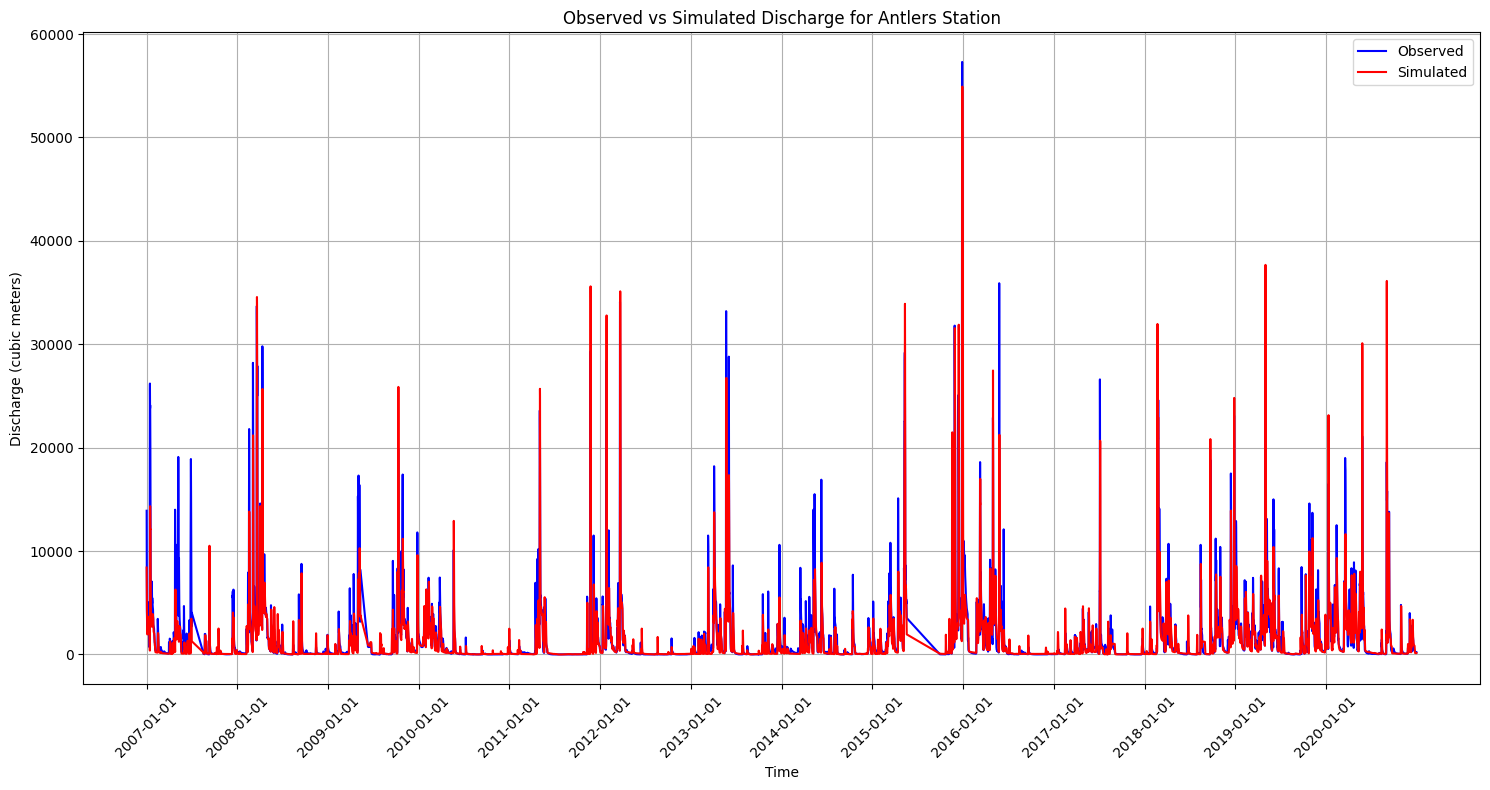

In [8]:
from plot_utils import plot_observed_vs_simulated_time_series

# Plot observed vs simulated discharge time series for Antlers station
plot_observed_vs_simulated_time_series(df_anto_merge, df_anto_merge, 'Antlers')




**BenchMarking the Existing Physics Based Model**

In [9]:

# Calculate NSE for Antlers station
nse_antlers = nse_utils.calculate_nse_for_station(df_anto_merge, df_anto_merge)


print("NSE for Antlers station:", nse_antlers)



NSE for Antlers station: 0.724296028334011


In [10]:
df_anto_merge.head()

,org,site_num,datetime,timezone,USGS_Discharge,quality,Sim_Discharge
0,USGS,7336200,2007-01-01 06:00:00+00:00,UTC,13900.0,A:[91],8404
1,USGS,7336200,2007-01-01 12:00:00+00:00,UTC,10100.0,A:[91],7821
2,USGS,7336200,2007-01-01 18:00:00+00:00,UTC,6870.0,A:[91],7006
3,USGS,7336200,2007-01-02 00:00:00+00:00,UTC,5080.0,A:[91],6090
4,USGS,7336200,2007-01-02 06:00:00+00:00,UTC,4180.0,A:[91],5257


**Scaling - Standardization**

In [11]:


# Calculate the mean and standard deviation of the Sim_Discharge column
sim_discharge_mean = df_anto_merge['Sim_Discharge'].mean()
sim_discharge_std = df_anto_merge['Sim_Discharge'].std()

# Standardize the Sim_Discharge column
df_anto_merge['Sim_Discharge_Standardized'] = (df_anto_merge['Sim_Discharge'] - sim_discharge_mean) / sim_discharge_std

# Optionally, standardize the USGS_Discharge column
usgs_discharge_mean = df_anto_merge['USGS_Discharge'].mean()
usgs_discharge_std = df_anto_merge['USGS_Discharge'].std()
df_anto_merge['USGS_Discharge_Standardized'] = (df_anto_merge['USGS_Discharge'] - usgs_discharge_mean) / usgs_discharge_std

# Display the updated DataFrame
df_anto_merge.head()


,org,site_num,datetime,timezone,USGS_Discharge,quality,Sim_Discharge,Sim_Discharge_Standardized,USGS_Discharge_Standardized
0,USGS,7336200,2007-01-01 06:00:00+00:00,UTC,13900.0,A:[91],8404,2.253606,3.519537
1,USGS,7336200,2007-01-01 12:00:00+00:00,UTC,10100.0,A:[91],7821,2.067956,2.437490
2,USGS,7336200,2007-01-01 18:00:00+00:00,UTC,6870.0,A:[91],7006,1.808428,1.517750
3,USGS,7336200,2007-01-02 00:00:00+00:00,UTC,5080.0,A:[91],6090,1.516737,1.008049
4,USGS,7336200,2007-01-02 06:00:00+00:00,UTC,4180.0,A:[91],5257,1.251477,0.751774


**Splitting the Data**

In [12]:
df_anto_merge['datetime'] = pd.to_datetime(df_anto_merge['datetime'])

In [13]:
train_start, train_end = '2007-01-01 06:00:00+00:00', '2015-12-31 18:00:00+00:00'
val_start, val_end = '2016-01-01 00:00:00+00:00', '2018-12-31 18:00:00+00:00'
test_start, test_end = '2019-01-01 00:00:00+00:00', '2020-12-31 12:00:00+00:00'


In [14]:
train_start = pd.Timestamp(train_start)
train_end = pd.Timestamp(train_end)
val_start = pd.Timestamp(val_start)
val_end = pd.Timestamp(val_end)
test_start = pd.Timestamp(test_start)
test_end = pd.Timestamp(test_end)


In [15]:
df_anto_merge['datetime'] = pd.to_datetime(df_anto_merge['datetime'])
df_anto_train = df_anto_merge[(df_anto_merge['datetime'] >= train_start) & (df_anto_merge['datetime'] <= train_end)]
df_anto_val = df_anto_merge[(df_anto_merge['datetime'] >= val_start) & (df_anto_merge['datetime'] <= val_end)]
df_anto_test = df_anto_merge[(df_anto_merge['datetime'] >= test_start) & (df_anto_merge['datetime'] <= test_end)]


In [16]:
df_anto_train.head()

,org,site_num,datetime,timezone,USGS_Discharge,quality,Sim_Discharge,Sim_Discharge_Standardized,USGS_Discharge_Standardized
0,USGS,7336200,2007-01-01 06:00:00+00:00,UTC,13900.0,A:[91],8404,2.253606,3.519537
1,USGS,7336200,2007-01-01 12:00:00+00:00,UTC,10100.0,A:[91],7821,2.067956,2.437490
2,USGS,7336200,2007-01-01 18:00:00+00:00,UTC,6870.0,A:[91],7006,1.808428,1.517750
3,USGS,7336200,2007-01-02 00:00:00+00:00,UTC,5080.0,A:[91],6090,1.516737,1.008049
4,USGS,7336200,2007-01-02 06:00:00+00:00,UTC,4180.0,A:[91],5257,1.251477,0.751774


In [17]:

# Verify lengths of each set
print("Training data length:", len(df_anto_train))
print("Validation data length:", len(df_anto_val))
print("Testing data length:", len(df_anto_test))


Training data length: 11848
Validation data length: 3877
Testing data length: 2742


In [18]:
df_anto_train.head()

,org,site_num,datetime,timezone,USGS_Discharge,quality,Sim_Discharge,Sim_Discharge_Standardized,USGS_Discharge_Standardized
0,USGS,7336200,2007-01-01 06:00:00+00:00,UTC,13900.0,A:[91],8404,2.253606,3.519537
1,USGS,7336200,2007-01-01 12:00:00+00:00,UTC,10100.0,A:[91],7821,2.067956,2.437490
2,USGS,7336200,2007-01-01 18:00:00+00:00,UTC,6870.0,A:[91],7006,1.808428,1.517750
3,USGS,7336200,2007-01-02 00:00:00+00:00,UTC,5080.0,A:[91],6090,1.516737,1.008049
4,USGS,7336200,2007-01-02 06:00:00+00:00,UTC,4180.0,A:[91],5257,1.251477,0.751774


In [19]:
df_anto_merge.shape

(18467, 9)

In [20]:
# Drop columns except 'Sim_Discharge_Standardized' and 'USGS_Discharge'
df_anto_merged = df_anto_merge[['Sim_Discharge_Standardized', 'USGS_Discharge_Standardized']]

# Display the first few rows of the modified DataFrame
df_anto_merged.head()


,Sim_Discharge_Standardized,USGS_Discharge_Standardized
0,2.253606,3.519537
1,2.067956,2.437490
2,1.808428,1.517750
3,1.516737,1.008049
4,1.251477,0.751774


**Feature Engineering**

In [21]:
# Define a function to prepare the dataset for LSTM
def prepare_dataset(X_data, y_data, n_steps):
    df_as_np = X_data.to_numpy()
    df2_as_np = y_data.to_numpy()
    X, y = [], []
    for i in range(len(X_data) - n_steps):
        row = [[a] for a in df_as_np[i:i+n_steps]]
        X.append(row)
        label = df2_as_np[i+n_steps]
        y.append(label)
    return np.array(X), np.array(y)
n_steps = 10

In [22]:
# Preparing the dataset for training
X_train, y_train = prepare_dataset(df_anto_train['Sim_Discharge_Standardized'], df_anto_train['USGS_Discharge_Standardized'], n_steps)

# Preparing the dataset for validation
X_val, y_val = prepare_dataset(df_anto_val['Sim_Discharge_Standardized'], df_anto_val['USGS_Discharge_Standardized'], n_steps)

# Preparing the dataset for testing
X_test, y_test = prepare_dataset(df_anto_test['Sim_Discharge_Standardized'], df_anto_test['USGS_Discharge_Standardized'], n_steps)


In [23]:
X_train.shape, y_train.shape,X_val.shape, y_val.shape,X_test.shape, y_test.shape

((11838, 10, 1), (11838,), (3867, 10, 1), (3867,), (2732, 10, 1), (2732,))

In [24]:
print(X_train.shape)

(11838, 10, 1)


**Long Short Term Memory**

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer(input_shape=(10, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:

model1.compile(loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [27]:
history_1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size = 32)

Epoch 1/10
370/370 [==============================] - 9s 17ms/step - loss: 0.5679 - root_mean_squared_error: 0.7536 - val_loss: 0.2287 - val_root_mean_squared_error: 0.4782
Epoch 2/10
370/370 [==============================] - 4s 10ms/step - loss: 0.3807 - root_mean_squared_error: 0.6170 - val_loss: 0.2034 - val_root_mean_squared_error: 0.4510
Epoch 3/10
370/370 [==============================] - 4s 11ms/step - loss: 0.3447 - root_mean_squared_error: 0.5871 - val_loss: 0.1878 - val_root_mean_squared_error: 0.4334
Epoch 4/10
370/370 [==============================] - 5s 14ms/step - loss: 0.3209 - root_mean_squared_error: 0.5665 - val_loss: 0.2335 - val_root_mean_squared_error: 0.4833
Epoch 5/10
370/370 [==============================] - 4s 10ms/step - loss: 0.3105 - root_mean_squared_error: 0.5572 - val_loss: 0.1846 - val_root_mean_squared_error: 0.4297
Epoch 6/10
370/370 [==============================] - 4s 11ms/step - loss: 0.3005 - root_mean_squared_error: 0.5482 - val_loss: 0.1793 

**Performance**

In [29]:
# Since the X_val and y_val are the validation data
predictions = model1.predict(X_val)

# Create a DataFrame with predictions and actual values
df_result = pd.DataFrame({'Predictions': predictions.flatten(), 'Actual': y_val.flatten()})

# Print or use the DataFrame as needed
print(df_result)


121/121 [==============================] - 1s 4ms/step
      Predictions    Actual
0        0.893122  2.693764
1        0.919420  2.665289
2        0.908289  2.608339
3        0.866497  2.579865
4        0.671458  2.522915
...           ...       ...
3862     1.570329  0.504043
3863     1.412424  0.407228
3864     1.053210  0.333193
3865     0.752925  0.264853
3866    -0.183246  0.447093

[3867 rows x 2 columns]


**Calculating the NSE For LSTM**

In [30]:
y_mean = np.mean(y_val)  # Calculate the mean of actual target values

# Calculate the sum of squares of residuals
residuals = y_val - predictions.flatten()
SS_residuals = np.sum(residuals ** 2)

# Calculate the sum of squares of total
SS_total = np.sum((y_val - y_mean) ** 2)

# Calculate NSE
NSE = 1 - (SS_residuals / SS_total)

print("NSE value:", NSE)


NSE value: 0.7227400263023426


In [31]:
from sklearn.metrics import mean_squared_error

# Assuming y_test is your true target values
mse = mean_squared_error(y_val, predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.21958085942480676


**GRU**

In [32]:

# Build the GRU model
model2 = Sequential()
model2.add(InputLayer(input_shape=(10, 1)))
model2.add(GRU(64))  # GRU
model2.add(Dense(8, activation='relu'))  # Add activation parameter explicitly
model2.add(Dense(1, activation='linear'))  # Add activation parameter explicitly

# Compile the model
model2.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

# Print the model summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size = 32)

Epoch 1/10
370/370 [==============================] - 8s 12ms/step - loss: 0.4468 - root_mean_squared_error: 0.6685 - val_loss: 0.2270 - val_root_mean_squared_error: 0.4765
Epoch 2/10
370/370 [==============================] - 4s 10ms/step - loss: 0.3338 - root_mean_squared_error: 0.5778 - val_loss: 0.2073 - val_root_mean_squared_error: 0.4553
Epoch 3/10
370/370 [==============================] - 5s 13ms/step - loss: 0.3161 - root_mean_squared_error: 0.5623 - val_loss: 0.1953 - val_root_mean_squared_error: 0.4419
Epoch 4/10
370/370 [==============================] - 5s 12ms/step - loss: 0.3053 - root_mean_squared_error: 0.5525 - val_loss: 0.1887 - val_root_mean_squared_error: 0.4344
Epoch 5/10
370/370 [==============================] - 4s 11ms/step - loss: 0.2963 - root_mean_squared_error: 0.5444 - val_loss: 0.2076 - val_root_mean_squared_error: 0.4557
Epoch 6/10
370/370 [==============================] - 5s 14ms/step - loss: 0.2930 - root_mean_squared_error: 0.5413 - val_loss: 0.1901 

**Performance**

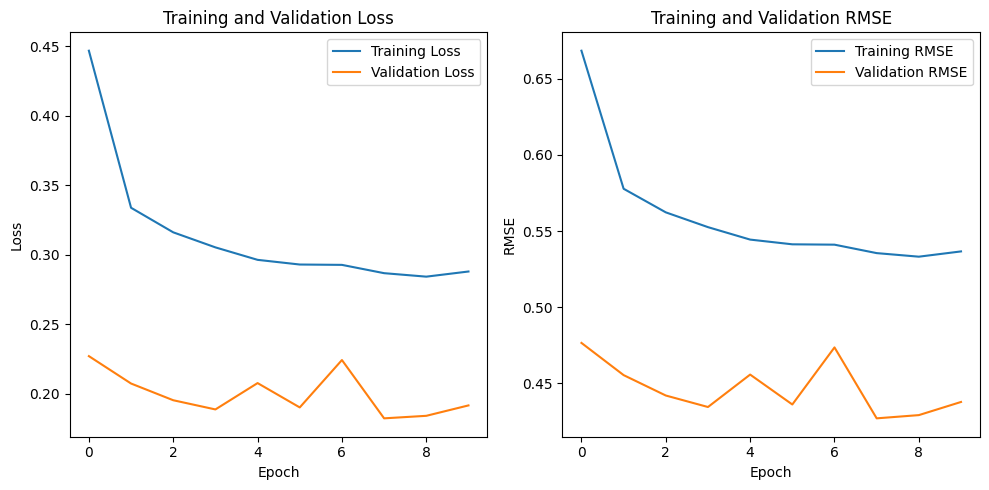

In [34]:
import matplotlib.pyplot as plt



# Plot training history
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:


# Since the X_val and y_val are the validation data
predictions_1 = model2.predict(X_val)

# Create a DataFrame with predictions and actual values
df_result = pd.DataFrame({'Predictions': predictions_1.flatten(), 'Actual': y_val.flatten()})

# Print or use the DataFrame as needed
print(df_result)


121/121 [==============================] - 1s 4ms/step
      Predictions    Actual
0        1.064029  2.693764
1        0.915492  2.665289
2        0.821338  2.608339
3        0.765051  2.579865
4        0.578554  2.522915
...           ...       ...
3862     1.500616  0.504043
3863     1.444406  0.407228
3864     1.287105  0.333193
3865     1.014562  0.264853
3866     0.123009  0.447093

[3867 rows x 2 columns]


**Calculating the NSE For GRU**

In [36]:
y_mean = np.mean(y_val)  # Calculate the mean of actual target values

# Calculate the sum of squares of residuals
residuals = y_val - predictions_1.flatten()
SS_residuals = np.sum(residuals ** 2)

# Calculate the sum of squares of total
SS_total = np.sum((y_val - y_mean) ** 2)

# Calculate NSE
NSE = 1 - (SS_residuals / SS_total)

print("NSE value:", NSE)


NSE value: 0.758125371973488
